In [ ]:
# ''' Do not change this cell '''
# #Functions

# def check_gpu():
#   if tf.test.gpu_device_name() != '':
#     print("GPU sucessfully connected")
#   else: print("PLease connect GPU")

# def check_data():
#   a = set()
#   for image in Images:
#     a.add(Image.shape[2])
#   if len(a)==1 and len(Images)==624:
#     print("PASS")
#   else: print("FAIL")

In [ ]:
#Import any library here only.
import os
import matplotlib.pyplot as plt
from PIL import Image,ImageEnhance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

data_dir = '/content/drive/MyDrive/Colab Notebooks/OpenCodeData/OpenCodeData'

images = []
labels = []

viral_count = 0
bacterial_count = 0

for root, dirs, files in os.walk(data_dir):
    for filename in files:
        if filename.endswith('.jpeg'):
            img_path = os.path.join(root, filename)
            if 'virus' in filename:
                labels.append('VIRAL')
                viral_count += 1
            elif 'bacteria' in filename:
                labels.append('BACTERIAL')
                bacterial_count += 1
            else:
                labels.append('NORMAL')

            images.append(img_path)

print(f"Number of Viral Images: {viral_count}")
print(f"Number of Bacterial Images: {bacterial_count}")

count_normal = sum(1 for label in labels if label == 'NORMAL')
count_infected = sum(1 for label in labels if label == 'BACTERIAL' or label == 'VIRAL' )

print(f"Count of NORMAL images: {count_normal}")
print(f"Count of INFECTED images: {count_infected}")

Number of Viral Images: 148
Number of Bacterial Images: 242
Count of NORMAL images: 234
Count of INFECTED images: 390


In [ ]:
from PIL import Image, ImageEnhance

def augment_images_inplace(images_list, labels_list, target_count):
    augmented_images = []
    augmented_labels = []
    count = 0

    for img_path, label in zip(images_list, labels_list):
        img = Image.open(img_path)
        if label == 'NORMAL' and count < target_count:
            rotated_images = [img.rotate(angle) for angle in [10, -10, 20, -20]]

            for rotated_img in rotated_images:
                augmented_images.append(rotated_img)
                augmented_labels.append(label)
                count += 1

            if count < target_count:
                flipped_image = img.transpose(Image.FLIP_LEFT_RIGHT)
                enhanced_image = ImageEnhance.Brightness(img).enhance(1.5)

                augmented_images.extend([flipped_image, enhanced_image])
                augmented_labels.extend([label, label])
                count += 2

        else:
            augmented_images.append(img)
            augmented_labels.append(label)

    return augmented_images, augmented_labels

target_count_normal = count_infected - count_normal
augmented_images, augmented_labels = augment_images_inplace(images, labels, target_count_normal)

In [ ]:
count_normal_augmented = sum(1 for label in augmented_labels if label == 'NORMAL')
count_infected_augmented = sum(1 for label in augmented_labels if label == 'BACTERIAL' or label == 'VIRAL')

print(f"Count of Normal/Augmented images: {count_normal_augmented}")
print(f"Count of Infected/Augmented images: {count_infected_augmented}")

Count of Normal/Augmented images: 364
Count of Infected/Augmented images: 390


In [ ]:
from sklearn.model_selection import train_test_split

train_images, test_val_images, train_labels, test_val_labels = train_test_split(
    augmented_images, augmented_labels, test_size=0.3, random_state=42
)

test_images, val_images, test_labels, val_labels = train_test_split(
    test_val_images, test_val_labels, test_size=0.5, random_state=42
)

print(f"Train set size: {len(train_images)}")
print(f"Test set size: {len(test_images)}")
print(f"Validation set size: {len(val_images)}")


Train set size: 527
Test set size: 113
Validation set size: 114


In [ ]:
from PIL import Image
import numpy as np
def preprocess_images_resnet(image_list, target_size):
    processed_images = []
    for item in image_list:
        if isinstance(item, str):
            img_path = item
            img = Image.open(img_path).resize(target_size).convert('RGB')
        else:
            img = item.resize(target_size).convert('RGB')

        processed_images.append(np.array(img))

    return np.array(processed_images)

target_size_resnet = (224, 224)

train_images_resnet = preprocess_images_resnet(train_images, target_size_resnet)
train_images_resnet = train_images_resnet / 255.0

val_images_resnet = preprocess_images_resnet(val_images, target_size_resnet)
val_images_resnet = val_images_resnet / 255.0

test_images_resnet = preprocess_images_resnet(test_images, target_size_resnet)
test_images_resnet = test_images_resnet / 255.0



# train_labels_np = np.array(train_labels)
# val_labels_np = np.array(val_labels)
# test_labels_np = np.array(test_labels)

label_mapping = {'VIRAL': 1, 'BACTERIAL': 1, 'NORMAL': 0}

encoded_train_labels = np.array([label_mapping[label] for label in train_labels])
encoded_val_labels = np.array([label_mapping[label] for label in val_labels])
encoded_test_labels = np.array([label_mapping[label] for label in test_labels])

# train_images_np = np.expand_dims(train_images_np, axis=-1)
# val_images_np = np.expand_dims(val_images_np, axis=-1)
# test_images_np = np.expand_dims(test_images_np, axis=-1)

In [ ]:
print("Shape of train_images_resnet:", train_images_resnet.shape)
print("Shape of val_images_resnet:", val_images_resnet.shape)
print("Shape of test_images_resnet:", test_images_resnet.shape)

Shape of train_images_resnet: (527, 224, 224, 3)
Shape of val_images_resnet: (114, 224, 224, 3)
Shape of test_images_resnet: (113, 224, 224, 3)


In [ ]:
val_images_resnet_truncated, encoded_val_labels_truncated = val_images_resnet[:113], encoded_val_labels[:113]
print(f"Truncated Validation images: {len(val_images_resnet_truncated)}, Truncated Validation labels: {len(encoded_val_labels_truncated)}")


Truncated Validation images: 113, Truncated Validation labels: 113


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_images_resnet, encoded_train_labels,
                    validation_data=(val_images_resnet, encoded_val_labels),
                    epochs=13, batch_size=32)

test_loss, test_acc = model.evaluate(test_images_resnet, encoded_test_labels)
print(f'Test accuracy: {test_acc * 100:.2f}%')


Epoch 1/13
17/17 [==============================] - 5s 191ms/step - loss: 0.6317 - accuracy: 0.5882 - val_loss: 0.5095 - val_accuracy: 0.8158
Epoch 2/13
17/17 [==============================] - 3s 161ms/step - loss: 0.4631 - accuracy: 0.8520 - val_loss: 0.4070 - val_accuracy: 0.8509
Epoch 3/13
17/17 [==============================] - 3s 150ms/step - loss: 0.3829 - accuracy: 0.8615 - val_loss: 0.3500 - val_accuracy: 0.8860
Epoch 4/13
17/17 [==============================] - 3s 159ms/step - loss: 0.3260 - accuracy: 0.8899 - val_loss: 0.3089 - val_accuracy: 0.8860
Epoch 5/13
17/17 [==============================] - 3s 159ms/step - loss: 0.2965 - accuracy: 0.8937 - val_loss: 0.2810 - val_accuracy: 0.8947
Epoch 6/13
17/17 [==============================] - 3s 149ms/step - loss: 0.2692 - accuracy: 0.9089 - val_loss: 0.2509 - val_accuracy: 0.9035
Epoch 7/13
17/17 [==============================] - 3s 154ms/step - loss: 0.2488 - accuracy: 0.9108 - val_loss: 0.2356 - val_accuracy: 0.9123
Epoch 

4/4 [==============================] - 1s 114ms/step
ROC AUC for test data: 0.9831


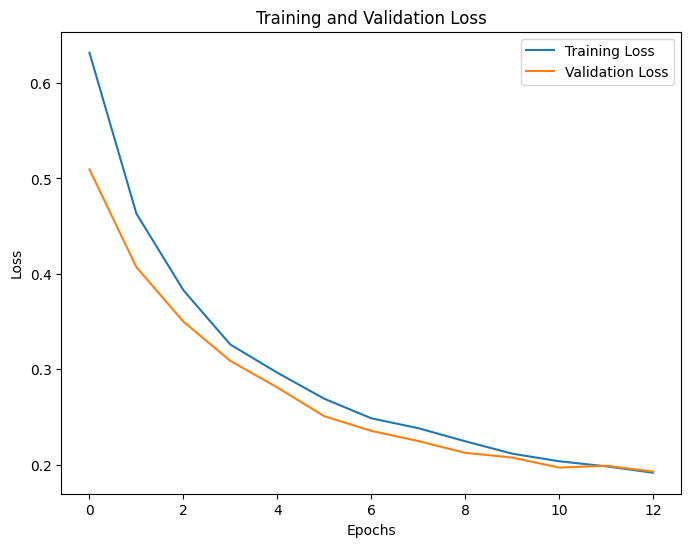

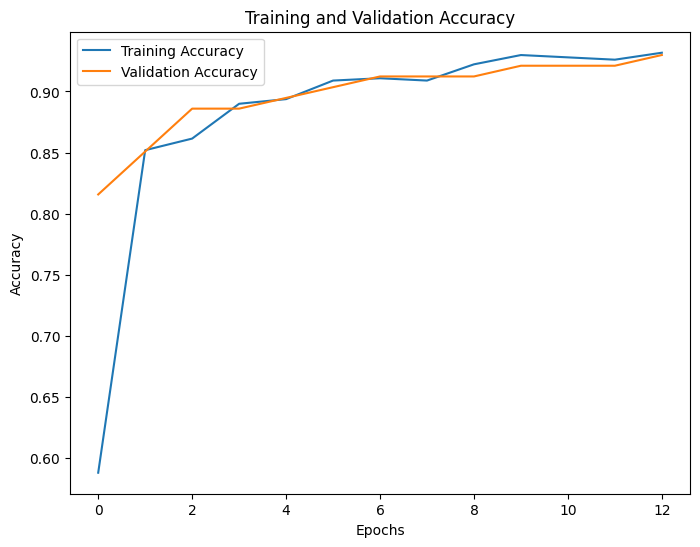

4/4 [==============================] - 0s 115ms/step - loss: 0.1876 - accuracy: 0.9381
Test accuracy: 93.81%


In [ ]:
from sklearn.metrics import roc_auc_score

test_probs = model.predict(test_images_resnet)
roc_auc = roc_auc_score(encoded_test_labels, test_probs)
print(f'ROC AUC for test data: {roc_auc:.4f}')

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('loss_plot.jpg')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('accuracy_plot.jpg')
plt.show()


test_loss, test_acc = model.evaluate(test_images_resnet, encoded_test_labels)
print(f'Test accuracy: {test_acc * 100:.2f}%')

4/4 [==============================] - 0s 114ms/step


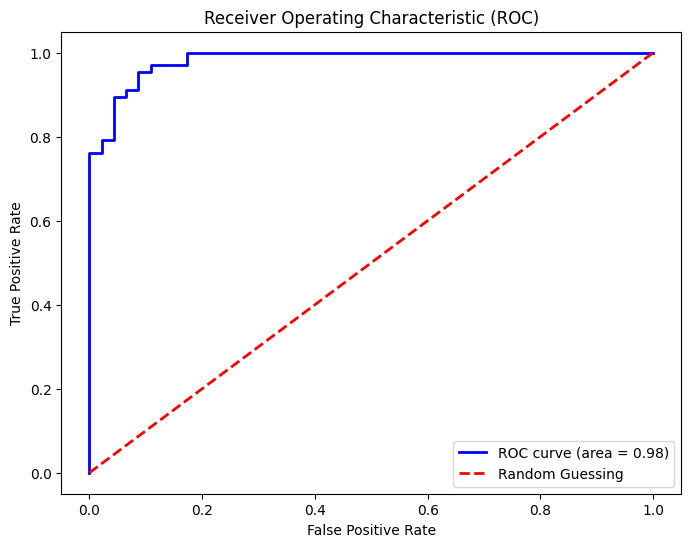

In [ ]:

y_pred = model.predict(test_images_resnet)

fpr, tpr, thresholds = roc_curve(encoded_test_labels, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.savefig('roc_curve.jpg')
plt.show()

In [ ]:
model.save('resnet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
